# Test Standardization of MRIs with Atlas

### Steps:
1. import registration atlas
2. import image
3. get registration atlas voxel intensity
4. Select 0.02 and 0.98 intensity percentile from atlas as reference
5. Apply MinMax scaling ? or take mean and std?. 

In [1]:
import os
import sys
module_path = os.path.abspath('../utils')
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
import ants


%load_ext autoreload
%autoreload 2
plt.style.use('seaborn')


In [2]:
output_path = "/home/lucasthim1/alzheimer_data/test/registration_test/01_affine_s3/"
input_path = "/home/lucasthim1/alzheimer_data/test/002_S_4270/MT1__N3m/2011-10-11_07_59_12.0/S125083/ADNI_002_S_4270_MR_MT1__N3m_Br_20111015081648646_S125083_I261073.nii"
second_input_path = "/home/lucasthim1/alzheimer_data/test/002_S_4264/MT1__N3m/2011-10-05_17_44_37.0/S124589/ADNI_002_S_4264_MR_MT1__N3m_Br_20111015080246439_S124589_I261067.nii"
atlas_path = '/home/lucasthim1/alzheimer_data/Atlas/atlas_t1.nii'

In [3]:
fixed = ants.image_read(atlas_path)
moving = ants.image_read(input_path)
moving_2 = ants.image_read(second_input_path)


In [41]:
def plot_intensity(image,title = 'Voxel Intensity Visualization',cumulative=False,log_scale = True):

    if type(image) is np.ndarray:
        img_flatten = image.ravel()
    else:
        img_flatten = image.numpy().ravel()
    if cumulative:
        sns.histplot(img_flatten,bins=100,cumulative=True,stat='density',log_scale=[False, log_scale])
    else:
        sns.histplot(img_flatten,bins=100,log_scale=[False, log_scale])
    plt.title(title)
    plt.xlabel('Voxel intensity')
    plt.show()

def get_mean_and_std(img,lower_bound=0.02,upper_bound = 99.8):
    lower_perc,upper_perc = get_percentiles(img,lower_bound=lower_bound,upper_bound=upper_bound)
    img_flatten = img.numpy().ravel()
    
    img_flatten[img_flatten > upper_perc] = upper_perc
    img_flatten[img_flatten < lower_perc] = lower_perc

    return img_flatten.mean(),img_flatten.std()

def get_percentiles(img,lower_bound=0.02,upper_bound = 99.8):
    img_flatten = img.numpy().ravel()
    lower_perc = np.percentile(img_flatten,q=lower_bound)
    upper_perc = np.percentile(img_flatten,q=upper_bound)
    return lower_perc,upper_perc

def scale_image_linearly(img_array:np.ndarray,lower_bound,upper_bound):
    img_array = (img_array - lower_bound) / (upper_bound - lower_bound)
    return img_array

def clip_image_intensity(image:np.ndarray,lower_threshold,upper_threshold):
    image[image > upper_threshold] = upper_threshold
    image[image < lower_threshold] = lower_threshold
    return image

def get_atlas_thresholds(atlas_path = None,lower_bound=0.02,upper_bound=99.8):
    
    if atlas_path is None: return (0.05545412003993988, 92.05744171142578) #for 0.02 and 99.8

    fixed = ants.image_read(atlas_path)
    return get_percentiles(fixed,lower_bound=lower_bound, upper_bound = upper_bound)

def apply_clipping_and_normalization(image, lower_bound = 0.02, upper_bound = 99.8):

    lower_threshold,upper_threshold = get_percentiles(image,lower_bound=lower_bound, upper_bound = upper_bound)
    image_clipped = clip_image_intensity(image.numpy(),lower_threshold=lower_threshold, upper_threshold=upper_threshold)
    lower_atlas_threshold, upper_atlas_threshold = get_atlas_thresholds()
    image_scaled = scale_image_linearly(image_clipped,lower_atlas_threshold,upper_atlas_threshold)
    return image_scaled

## Checking Image distributions

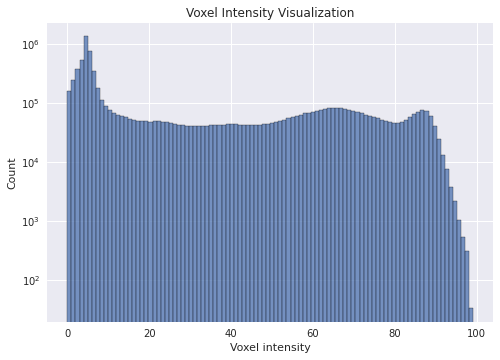

In [6]:
plot_intensity(fixed.numpy(),cumulative=False)


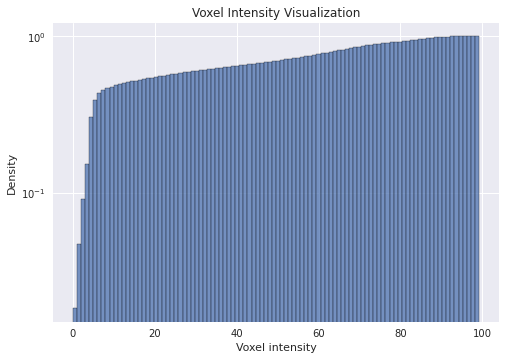

In [7]:
plot_intensity(fixed,cumulative=True)

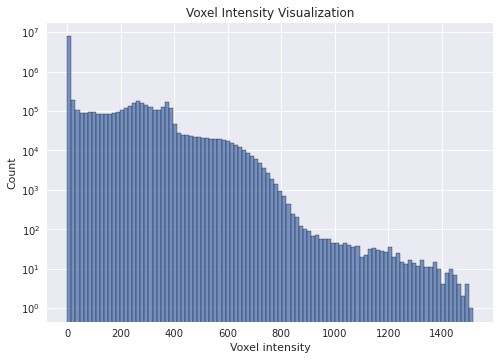

In [18]:
plot_intensity(moving,cumulative=False)

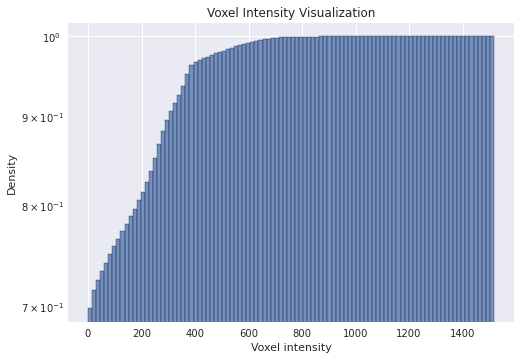

In [19]:
plot_intensity(moving,cumulative=True)

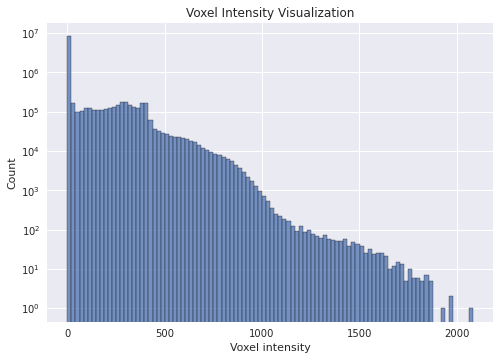

In [20]:
plot_intensity(moving_2,cumulative=False)

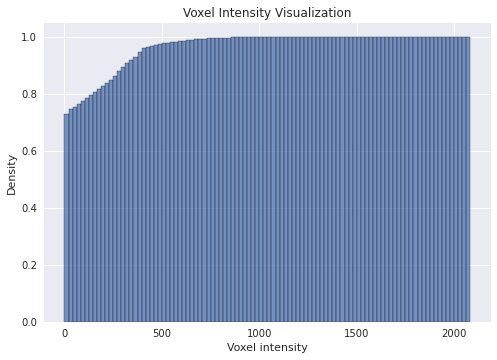

In [102]:
plot_intensity(moving_2,cumulative=True)

## Analyzing percentiles

In [9]:
upper_bound = 99.8
lower_bound = 0.02
lower_value, upper_value = get_percentiles(fixed,upper_bound = upper_bound,lower_bound=lower_bound)
mean_fixed, std_fixed = get_mean_and_std(fixed)
lower_value, upper_value

(0.05545412003993988, 92.05744171142578)

In [10]:
lower_threshold,upper_threshold = get_percentiles(moving,upper_bound = upper_bound,lower_bound=lower_bound)
lower_threshold,upper_threshold

(0.0, 702.4865462646486)

In [11]:
get_percentiles(moving_2,upper_bound = upper_bound,lower_bound=lower_bound)

(0.0, 849.1487662353519)

In [13]:
mean_moving, std_moving = get_mean_and_std(moving,upper_bound=99.8,lower_bound=0.0)
mean_moving, std_moving

(76.8966, 142.33131)

## Clipping and Scaling Images

In [14]:
lower_threshold,upper_threshold = get_percentiles(moving,upper_bound = upper_bound,lower_bound=lower_bound)
moving_clipped = clip_image_intensity(moving.numpy(),lower_threshold=lower_threshold, upper_threshold=upper_threshold)

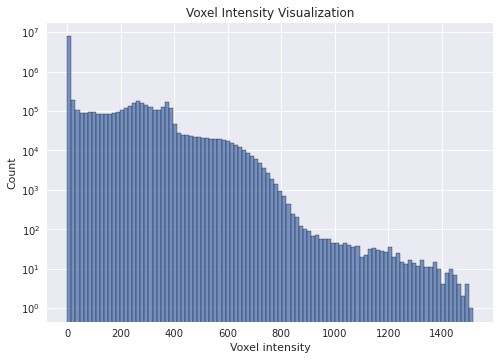

In [15]:
plot_intensity(moving,log_scale=False)

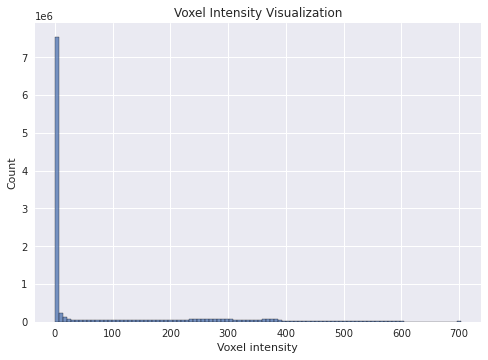

In [18]:
plot_intensity(moving_clipped,log_scale=False)

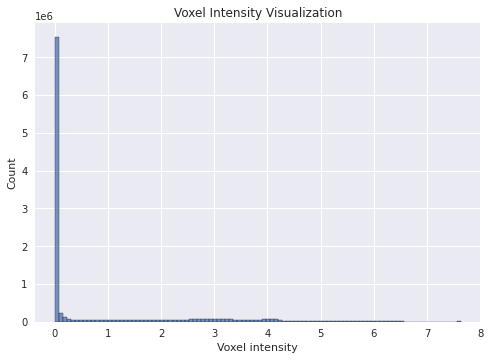

In [21]:
moving_scaled = scale_image_linearly(moving_clipped,upper_value,lower_value)
plot_intensity(moving_scaled,log_scale=False)

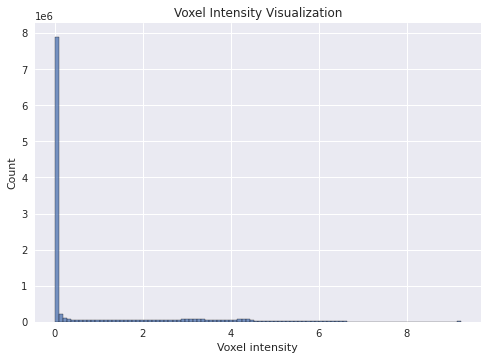

In [22]:
lower_threshold,upper_threshold = get_percentiles(moving_2,upper_bound = upper_bound,lower_bound=lower_bound)
moving_clipped_2 = clip_image_intensity(moving_2.numpy(),lower_threshold=lower_threshold, upper_threshold=upper_threshold)
moving_scaled_2 = scale_image_linearly(moving_clipped_2,upper_value,lower_value)
plot_intensity(moving_scaled_2,log_scale=False)

## Apply Final Transforms

In [33]:
moving = ants.image_read(input_path)
final_moving = apply_clipping_and_normalization(moving)

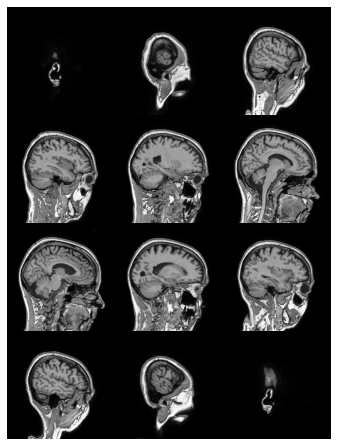

In [36]:
final_img_ants = ants.from_numpy(final_moving)
final_img_ants.plot()

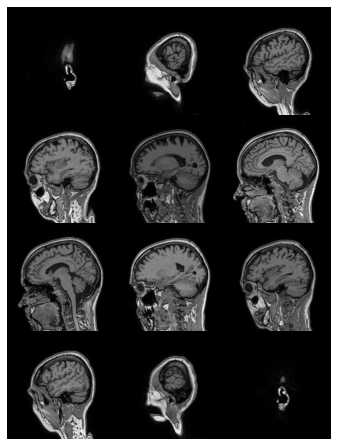

In [42]:
moving.plot()

In [38]:
final_img_ants.to_file("sample.nii.gz")

/home/lucasthim1/miniconda3/envs/deepbrain/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



/home/lucasthim1/miniconda3/envs/deepbrain/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



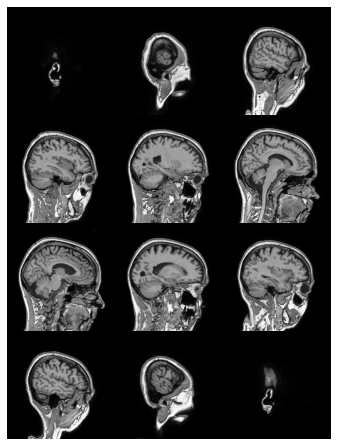

In [39]:
sample = ants.image_read("sample.nii.gz")
sample.plot()

## Normalizing Data by Parts

In [ ]:
def normalizaSeriePorTrechos(serie,trechos,probabilidades,showPlot=False):
    
    serie_normalizada = []
    for i in range(serie.size):
        valor = serie.iloc[i].values[0]
        indice_maior = np.where(np.array(trechos)  > valor)[0][0]
        serie_normalizada.append(normalizaNumero(numero=valor,probMin=probabilidades[indice_maior-1],probMax=probabilidades[indice_maior],valorMin=trechos[indice_maior-1],valorMax=trechos[indice_maior]))
    serie_normalizada = np.array(serie_normalizada)
    if(showPlot):
        dataSetparaPlot = pd.DataFrame(serie_normalizada,columns=['Série Normalizada'],index= pd.to_datetime(serie.index)) 
        ax = dataSetparaPlot.plot(figsize=(12,7),grid=True)
        plt.show()
    
    dataSetNormalizado = pd.DataFrame(serie_normalizada,columns=['Série Normalizada'],index=serie.index)
    
    return dataSetNormalizado